In [1]:
# import statements
import pandas as pd

## Meds tensor analysis

In [5]:
diag = pd.read_csv("data/raw/DIAGNOSES_ICD.csv", usecols=["SUBJECT_ID", "HADM_ID", "ICD9_CODE"])
diag

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,40301
1,109,172335,486
2,109,172335,58281
3,109,172335,5855
4,109,172335,4254
...,...,...,...
651042,97503,188195,20280
651043,97503,188195,V5869
651044,97503,188195,V1279
651045,97503,188195,5275


In [7]:
meds = pd.read_csv("data/raw/PRESCRIPTIONS.csv", usecols=["SUBJECT_ID", "HADM_ID", "DRUG"])
meds

,SUBJECT_ID,HADM_ID,DRUG
0,6,107064,Tacrolimus
1,6,107064,Warfarin
2,6,107064,Heparin Sodium
3,6,107064,D5W
4,6,107064,Furosemide
...,...,...,...
4156445,98887,121032,PredniSONE
4156446,98887,121032,Ipratropium Bromide Neb
4156447,98887,121032,HYDROmorphone (Dilaudid)
4156448,98887,121032,Docusate Sodium


In [11]:
# Analysing prescription dataset
print("Missing values: ",meds.isnull().sum())
print("\nValue counts for DRUGS: ", meds["DRUG"].value_counts())

Missing values:  SUBJECT_ID    0
HADM_ID       0
DRUG          0
dtype: int64

Value counts for DRUGS:  DRUG
Potassium Chloride      192993
Insulin                 143465
D5W                     142241
Furosemide              133122
0.9% Sodium Chloride    130147
                         ...  
Renaphro                     1
Morphine Sulfat              1
humulin R                    1
Meperidine PCA               1
rasagiline (Azilect)         1
Name: count, Length: 4525, dtype: int64


## Labs tensor analysis

In [18]:
labs = pd.read_csv("data/raw/LABEVENTS.csv", usecols=["SUBJECT_ID", "HADM_ID", "ITEMID", "FLAG"])
labs

,SUBJECT_ID,HADM_ID,ITEMID,FLAG
0,3,NaN,50820,NaN
1,3,NaN,50800,NaN
2,3,NaN,50802,NaN
3,3,NaN,50804,NaN
4,3,NaN,50808,abnormal
...,...,...,...,...
27854050,96443,103219.0,50882,NaN
27854051,96443,103219.0,50885,abnormal
27854052,96443,103219.0,50902,NaN
27854053,96443,103219.0,50911,NaN


### Process labs dataframe

In [20]:
labs["FLAG"] = labs["FLAG"].fillna("normal")
labs

,SUBJECT_ID,HADM_ID,ITEMID,FLAG
0,3,NaN,50820,normal
1,3,NaN,50800,normal
2,3,NaN,50802,normal
3,3,NaN,50804,normal
4,3,NaN,50808,abnormal
...,...,...,...,...
27854050,96443,103219.0,50882,normal
27854051,96443,103219.0,50885,abnormal
27854052,96443,103219.0,50902,normal
27854053,96443,103219.0,50911,normal


In [ ]:
labs = labs.dropna(subset = ["HADM_ID"])
labs

In [25]:
labs.isna().sum()

SUBJECT_ID    0
HADM_ID       0
ITEMID        0
FLAG          0
dtype: int64

## LDA visualisations

### Get pehnotypes list

In [121]:
import pandas as pd

# Load data
drugs_df  = pd.read_csv("data/lda_out/drugs.csv", index_col=0)
labs_df   = pd.read_csv("data/lda_out/labs.csv", index_col=0)
notes_df  = pd.read_csv("data/lda_out/notes.csv", index_col=0)
icd9_df   = pd.read_csv("data/lda_out/diagnoses.csv", index_col=0)

# Parameters
R = 30           # number of topics
TOP_N = 5        # items per view
OUT_PATH = "phenotypes/lda.md"

with open(OUT_PATH, "w", encoding="utf-8") as f:
    for r in range(R):
        f.write(f"## Phenotype {r+1}\n\n")

        def get_tokens(df):
            return ", ".join(df[str(r)].sort_values(ascending=False).head(TOP_N).index)

        if not drugs_df.empty:
            f.write(f"**Meds**: {get_tokens(drugs_df)}  \n")
        if not labs_df.empty:
            f.write(f"**Labs**: {get_tokens(labs_df)}  \n")
        if not notes_df.empty:
            f.write(f"**Notes**: {get_tokens(notes_df)}  \n")
        if not icd9_df.empty:
            f.write(f"**ICD9 Diagnoses**: {get_tokens(icd9_df)}  \n")

        f.write("\n")  # space between cards

### Sparsity chart

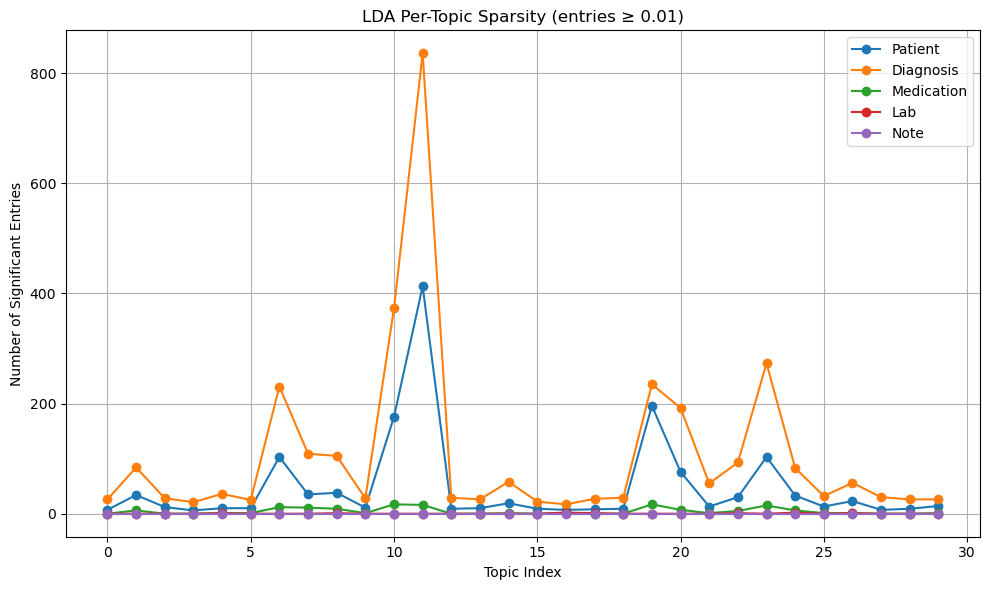

In [81]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load LDA mode matrices
patients = pd.read_csv("data/lda_out/patients.csv", index_col=0)
diagnoses = pd.read_csv("data/lda_out/diagnoses.csv", index_col=0)
drugs = pd.read_csv("data/lda_out/drugs.csv", index_col=0)
labs = pd.read_csv("data/lda_out/labs.csv", index_col=0)
notes = pd.read_csv("data/lda_out/notes.csv", index_col=0)

# Sparsity function
def compute_sparsity(df, threshold=0.01):
    A = df.to_numpy()
    return np.sum(A >= threshold, axis=0)

# Get sparsity per component (topic)
sparsity = {
    "Patient": compute_sparsity(patients),
    "Diagnosis": compute_sparsity(diagnoses),
    "Medication": compute_sparsity(drugs),
    "Lab": compute_sparsity(labs),
    "Note": compute_sparsity(notes)
}

# Plot
topics = np.arange(patients.shape[1])
plt.figure(figsize=(10, 6))
for mode, values in sparsity.items():
    plt.plot(topics, values, marker='o', label=mode)

plt.title("LDA Per-Topic Sparsity (entries ≥ 0.01)")
plt.xlabel("Topic Index")
plt.ylabel("Number of Significant Entries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Topic distributions plot

In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lda_out_dir = "data/lda_out/"
out_path = "scree_lda.png"

lambda_meds  = pd.read_csv(os.path.join(lda_out_dir, "lambda_meds.csv"))["lambda_meds"]
lambda_labs  = pd.read_csv(os.path.join(lda_out_dir, "lambda_labs.csv"))["lambda_labs"]
lambda_notes = pd.read_csv(os.path.join(lda_out_dir, "lambda_notes.csv"))["lambda_notes"]

R = len(lambda_meds)
xs = np.arange(R)

plt.figure(figsize=(10, 5))
plt.plot(xs, lambda_meds, label="Meds λ", marker='o')
plt.plot(xs, lambda_labs, label="Labs λ", marker='s')
plt.plot(xs, lambda_notes, label="Notes λ", marker='^')
plt.title("LDA: Topic Weights per View")
plt.xlabel("Topic index")
plt.ylabel("Weight (λ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_path = os.path.join(lda_out_dir, out_path)
plt.savefig(save_path)
plt.close()
print(f"[Plot] LDA scree plot saved to {save_path}")

[Plot] LDA scree plot saved to data/lda_out/scree_lda.png


## Granite single view visualisations

### Get pehnotypes list

In [119]:
import pandas as pd

# Load data
drugs_df = pd.read_csv("data/granite_out/drugs.csv", index_col=0)
diagnoses_df  = pd.read_csv("data/granite_out/diagnoses.csv", index_col=0)

# Parameters
R = 30           # number of components
TOP_N = 5        # items per view
OUT_PATH = "phenotypes/granite_single.md"

with open(OUT_PATH, "w", encoding="utf-8") as f:
    for r in range(R):
        f.write(f"## Phenotype {r+1}\n\n")

        if not drugs_df.empty:
            top_drugs = drugs_df[str(r)].sort_values(ascending=False).head(TOP_N).index.tolist()
            f.write(f"**Meds**: {', '.join(top_drugs)}  \n")

        if not diagnoses_df.empty:
            top_diags = diagnoses_df[str(r)].sort_values(ascending=False).head(TOP_N).index.tolist()
            f.write(f"**ICD9 Diagnoses**: {', '.join(top_diags)}  \n")

        f.write("\n")

### Sparsity chart

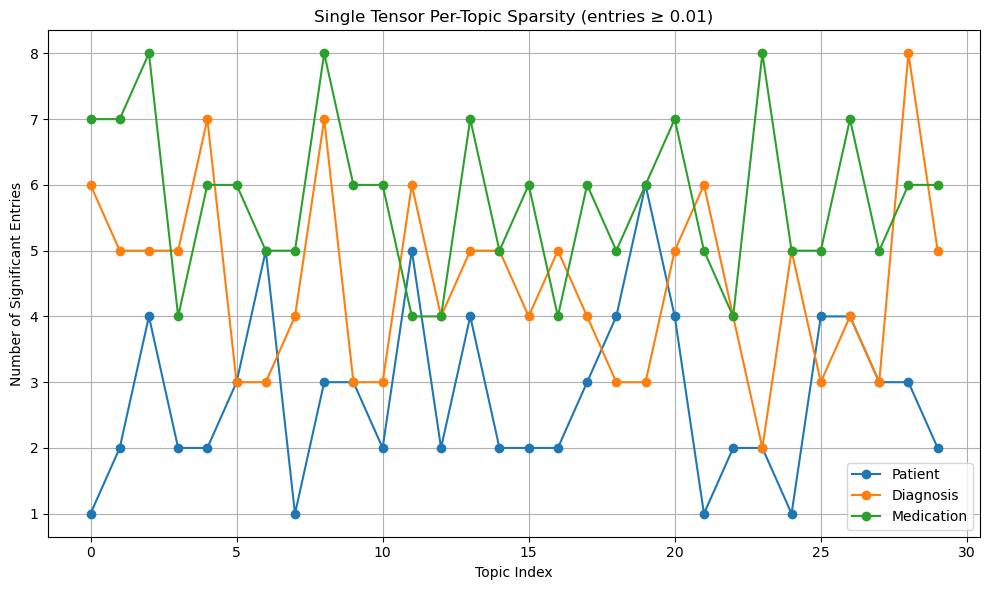

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Granite factor matrices (single tensor)
granite_dir = "data/granite_out/"
patients = pd.read_csv(granite_dir + "patients.csv", index_col=0)
diagnoses = pd.read_csv(granite_dir + "diagnoses.csv", index_col=0)
drugs = pd.read_csv(granite_dir + "drugs.csv", index_col=0)

# Sparsity function
def compute_sparsity(df, threshold=0.01):
    A = df.to_numpy()
    return np.sum(A >= threshold, axis=0)

# Calculate sparsity per component/topic
sparsity = {
    "Patient": compute_sparsity(patients),
    "Diagnosis": compute_sparsity(diagnoses),
    "Medication": compute_sparsity(drugs)
}

# Plot sparsity
topics = np.arange(patients.shape[1])
plt.figure(figsize=(10, 6))
for mode, values in sparsity.items():
    plt.plot(topics, values, marker='o', label=mode)

plt.title("Single Tensor Per-Topic Sparsity (entries ≥ 0.01)")
plt.xlabel("Topic Index")
plt.ylabel("Number of Significant Entries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Topic distributions plot

In [105]:
granite_out_dir="data/granite_out"
out_path="scree_granite.png"
lambda_meds = pd.read_csv(os.path.join(granite_out_dir, "lambda_meds.csv"))["lambda_meds"]

R = len(lambda_meds)
xs = np.arange(R)

plt.figure(figsize=(8, 4))
plt.plot(xs, lambda_meds, label="Meds λ", marker='o', color='purple')
plt.title("Single Tensor: Component Weights")
plt.xlabel("Component index")
plt.ylabel("Weight (λ)")
plt.grid(True)
plt.tight_layout()
save_path = os.path.join(granite_out_dir, out_path)
plt.savefig(save_path)
plt.close()
print(f"[Plot] Granite scree plot saved to {save_path}")

[Plot] Granite scree plot saved to data/granite_out/scree_granite.png


## Granite multi view visualisations

### Get pehnotypes list

In [117]:
import pandas as pd

# Load data
drugs_df = pd.read_csv("data/granite3_out/drugs.csv", index_col=0)
labs_df = pd.read_csv("data/granite3_out/labs.csv", index_col=0)
notes_df = pd.read_csv("data/granite3_out/notes.csv", index_col=0)
diagnoses_df = pd.read_csv("data/granite3_out/diagnoses.csv", index_col=0)

# Parameters
R = 30           # number of components
TOP_N = 5        # items per view
OUT_PATH = "phenotypes/granite_multiview.md"

with open(OUT_PATH, "w", encoding="utf-8") as f:
    for r in range(R):
        f.write(f"## Phenotype {r+1}\n\n")

        if not drugs_df.empty:
            top_drugs = drugs_df[str(r)].sort_values(ascending=False).head(TOP_N).index.tolist()
            f.write(f"**Meds**: {', '.join(top_drugs)}  \n")

        if not labs_df.empty:
            top_labs = labs_df[str(r)].sort_values(ascending=False).head(TOP_N).index.tolist()
            f.write(f"**Labs**: {', '.join(top_labs)}  \n")

        if not notes_df.empty:
            top_notes = notes_df[str(r)].sort_values(ascending=False).head(TOP_N).index.tolist()
            f.write(f"**Notes**: {', '.join(top_notes)}  \n")

        if not diagnoses_df.empty:
            top_diags = diagnoses_df[str(r)].sort_values(ascending=False).head(TOP_N).index.tolist()
            f.write(f"**ICD9 Diagnoses**: {', '.join(top_diags)}  \n")

        f.write("\n")

### Sparsity chart

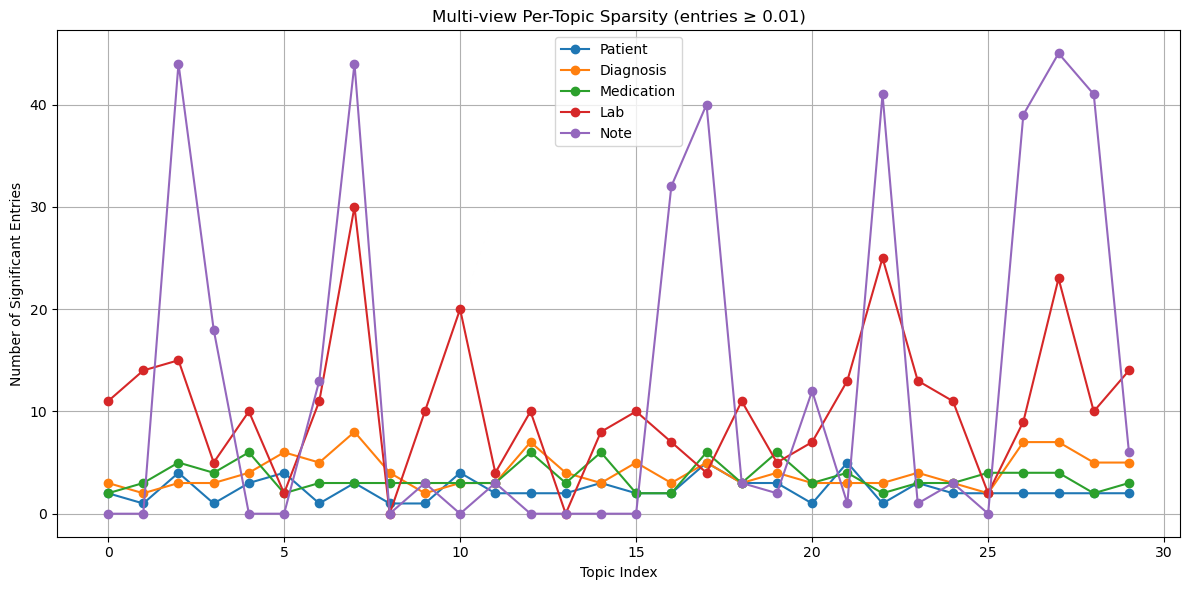

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load all Granite3 factors
granite3_dir = "data/granite3_out/"
patients = pd.read_csv(granite3_dir + "patients.csv", index_col=0)
diagnoses = pd.read_csv(granite3_dir + "diagnoses.csv", index_col=0)
drugs = pd.read_csv(granite3_dir + "drugs.csv", index_col=0)
labs = pd.read_csv(granite3_dir + "labs.csv", index_col=0)
notes = pd.read_csv(granite3_dir + "notes.csv", index_col=0)

# Sparsity function
def compute_sparsity(df, threshold=0.01):
    A = df.to_numpy()
    return np.sum(A >= threshold, axis=0)

# Compute per-component sparsity
sparsity = {
    "Patient": compute_sparsity(patients),
    "Diagnosis": compute_sparsity(diagnoses),
    "Medication": compute_sparsity(drugs),
    "Lab": compute_sparsity(labs),
    "Note": compute_sparsity(notes)
}

# Plot sparsity
topics = np.arange(patients.shape[1])
plt.figure(figsize=(12, 6))
for mode, values in sparsity.items():
    plt.plot(topics, values, marker='o', label=mode)

plt.title("Multi-view Per-Topic Sparsity (entries ≥ 0.01)")
plt.xlabel("Topic Index")
plt.ylabel("Number of Significant Entries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Topic distributions plot

In [111]:
granite3_out_dir="data/granite3_out"
out_path="scree_granite3.png"
lambda_meds  = pd.read_csv(os.path.join(granite3_out_dir, "lambda_meds.csv"))
lambda_labs  = pd.read_csv(os.path.join(granite3_out_dir, "lambda_labs.csv"))
lambda_notes = pd.read_csv(os.path.join(granite3_out_dir, "lambda_notes.csv"))

R = len(lambda_meds)
xs = np.arange(R)

plt.figure(figsize=(10, 5))
plt.plot(xs, lambda_meds, label="Meds λ", marker='o')
plt.plot(xs, lambda_labs, label="Labs λ", marker='s')
plt.plot(xs, lambda_notes, label="Notes λ", marker='^')
plt.title("Multi-view tensor: Topic Weights per View")
plt.xlabel("Component index")
plt.ylabel("Weight (λ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_path = os.path.join(granite3_out_dir, out_path)
plt.savefig(save_path)
plt.close()
print(f"[Plot] Granite3 scree plot saved to {save_path}")

[Plot] Granite3 scree plot saved to data/granite3_out/scree_granite3.png
